In [ ]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import numpy as np
import pandas as pd
import re

In [ ]:
###LOAD FILE WITH INTENSITY DATA PER CELL
cleaned_csv_path = "/content/drive/MyDrive/NASA Ames summer 2024/SVC_code/cleaned_counterstain_data_with_metadata.csv"
final_df = pd.read_csv(cleaned_csv_path)

In [ ]:
##COMPUTE LOWER CUTOFFS FOR EACH CHANNEL FROM THE SECONDARY CONTROL PLATES (plates with no primary antibody)

secondary_controls = [893, 897, 902, 906]
channel = "Mean_AF594"
q = 0.99   # try 0.95, 0.975, or 0.99

upper_bg_per_plate = (
    final_df[
        final_df["plate"].isin(secondary_controls) &
        final_df[channel].notna() &
        (final_df[channel] > 0)
    ]
    .assign(log_intensity=lambda d: np.log1p(d[channel]))
    .groupby("plate")["log_intensity"]
    .quantile(q)
    .reset_index(name=f"log_intensity_q{int(q*1000)/10}")
)

upper_bg_per_plate

,plate,log_intensity_q99.0
0,893,4.839406
1,897,5.039221
2,902,4.860697
3,906,4.830114


In [ ]:
"""
Per-well fluorescence cutoffs using Gaussian Mixture Models (GMM)
================================================================

This script computes *per-well* intensity cutoffs for immunofluorescence channels
(e.g., AF594 and AF647) across all plates in a dataset. The goal is to determine,
for each (plate, well, channel), a threshold that separates a "negative/background"
population from higher-intensity signal.

Key features
-----------
1) Per-well modeling (not global):
   Each well can have different background distributions (staining variability,
   illumination, acquisition settings, etc.). We fit a model per well.

2) 1-GMM vs 2-GMM selection:
   - Fit both a 1-component Gaussian and a 2-component Gaussian to the log-transformed
     intensity distribution in that well.
   - Use BIC (Bayesian Information Criterion) to decide whether the extra component
     is justified (optionally requiring a margin `bic_margin`).

3) Cutoff definition:
   We define the cutoff based on the "negative" component:
       cutoff_log = mu_neg + z_q * sigma_neg
   where z_q is the standard-normal quantile (e.g., q=0.975).

4) Secondary-control floors (IMPORTANT):
   In practice, GMM can sometimes pick an unrealistically low cutoff (e.g., when
   distributions are too unimodal or have limited dynamic range). If you have
   negative/secondary control-derived floors (in log space), enforce:
       cutoff_log_final = max(cutoff_log_gmm, floor_log)

   This guarantees thresholds never fall below empirically determined baselines.

5) Output:
   A tidy DataFrame (and optional CSV) with cutoffs + diagnostics per well.

Assumptions / inputs
--------------------
- final_df contains columns for:
    - plate identifier (default: "plate")
    - well identifier (default: "Well")
    - fluorescence intensity channels (e.g., "Mean_AF594", "Mean_AF647")
- intensity values must be positive to be log-transformed
  (we use log1p so zeros are allowed, but still we filter to >0 for safety)

Notes on log transform
----------------------
We model log1p(intensity) rather than raw intensity because fluorescence intensity
often has heavy tails; log compresses outliers and yields more Gaussian-like
distributions.

"""

# ---------------------------------------------------------------------
# Helper: sort wells in natural plate order (A1, A2, ... A10, B1, ...)
# ---------------------------------------------------------------------
def well_sort_key(well: str):
    """
    Convert a well ID like 'B11' into a sortable key: ('B', 11).
    This keeps wells in human-readable plate order.
    """
    m = re.match(r"([A-Za-z]+)(\d+)", str(well))
    if m is None:
        # fallback: sort by raw string if formatting is unexpected
        return (str(well), 0)
    row, col = m.groups()
    return (row.upper(), int(col))


# ---------------------------------------------------------------------
# Main function: compute per-well cutoffs for all plates
# ---------------------------------------------------------------------
def compute_all_plate_well_cutoffs(
    final_df: pd.DataFrame,
    channels=("Mean_AF594", "Mean_AF647"),
    plate_col="plate",
    well_col="Well",
    id_col="ID",
    min_cells=50,
    q=0.975,
    random_state=42,
    bic_margin=0.0,
    out_csv_path=None,
    secondary_log_floors=None,
):
    """
    Compute per-well cutoffs across all plates for the requested fluorescence channels.

    Parameters
    ----------
    final_df : pd.DataFrame
        Input table containing per-cell intensity values and metadata.
        Must include plate_col, well_col, and each `channel` column.

    channels : tuple[str]
        Names of intensity columns to model (e.g., ("Mean_AF594", "Mean_AF647")).

    plate_col, well_col : str
        Column names for plate and well identifiers.

    id_col : str
        Optional ID column; not used in modeling directly but may be kept for
        debugging/traceability. If not present, ignored.

    min_cells : int
        Minimum number of cells required in a (plate, well) to fit a model.
        Wells with fewer cells are skipped.

    q : float
        Quantile used to define the cutoff from the negative component:
            cutoff_log = mu_neg + z_q * sigma_neg
        Example: q=0.975 -> z_q ≈ 1.96

    random_state : int
        Random seed for GMM initialization for reproducibility.

    bic_margin : float
        Additional required improvement in BIC to choose the 2-component model.
        We compute:
            delta_bic = bic1 - bic2
        If delta_bic > bic_margin -> prefer 2-GMM
        Else -> use 1-GMM.
        Note: larger margin makes 2-GMM selection more conservative.

    out_csv_path : str or None
        If provided, saves the output DataFrame to this CSV path.

    secondary_log_floors : dict or None
        Optional dict mapping channel -> log floor (float).
        Example:
            {"Mean_AF594": 5.1, "Mean_AF647": 6.06}
        If provided, enforce:
            cutoff_log_final = max(cutoff_log_gmm, floor_log)
        and record whether the floor was applied.

    Returns
    -------
    out : pd.DataFrame
        Table with one row per (plate, well, channel).
        Includes:
          - cutoff_log, cutoff_linear (final)
          - cutoff_log_gmm (raw GMM cutoff before floor)
          - secondary_floor_log, secondary_floor_applied
          - diagnostics (n_cells, model, delta_BIC, mu_neg, sd_neg, w_neg)
    """

    # -------------------------
    # Basic validation
    # -------------------------
    missing = [c for c in [plate_col, well_col] if c not in final_df.columns]
    if missing:
        raise ValueError(f"final_df missing required columns: {missing}")

    if secondary_log_floors is None:
        secondary_log_floors = {}

    # z-score corresponding to the requested quantile
    zq = float(norm.ppf(q))

    # Collect output rows here
    rows = []

    # Work on a copy so upstream data are not mutated
    df0 = final_df.copy()

    # -------------------------
    # Plate selection
    # -------------------------
    # This version intentionally restricts to Fe/Gamma plates, based on your project.
    # If you want all plates, remove this filter and just use df0[plate_col].
    if "radiation" not in df0.columns:
        raise ValueError(
            "Expected a 'radiation' column to filter Fe/Gamma plates. "
            "If your data uses a different column name, edit this section."
        )

    plates = (
        df0[df0["radiation"].astype(str).str.strip().isin(["Fe", "Gamma"])][plate_col]
        .dropna()
        .astype(str)
        .unique()
        .tolist()
    )
    plates = sorted(plates)
    print(f"Running cutoffs for Fe/Gamma plates only ({len(plates)}): {plates}")

    # -------------------------
    # Iterate channels
    # -------------------------
    for channel in channels:
        if channel not in df0.columns:
            raise ValueError(f"final_df missing channel column: {channel}")

        # Keep only the columns needed for this channel's modeling.
        use_cols = [plate_col, well_col, channel]
        if id_col in df0.columns:
            use_cols.append(id_col)

        dfc = df0[use_cols].copy()

        # Filter to valid, positive values
        # (log1p supports 0, but in practice intensity should be >0 for stable modeling)
        dfc = dfc[dfc[channel].notna() & (dfc[channel] > 0)].copy()
        if dfc.empty:
            print(f"[WARN] No valid data for channel={channel}; skipping.")
            continue

        # Precompute log transform once for efficiency
        dfc["_log"] = np.log1p(dfc[channel].values)

        # Secondary floor for this channel (if provided)
        floor_log = secondary_log_floors.get(channel, None)

        # -------------------------
        # Iterate plates and wells
        # -------------------------
        for plate_id in plates:
            dcp = dfc[dfc[plate_col].astype(str) == str(plate_id)]
            if dcp.empty:
                continue

            # Identify wells with enough cells
            counts = dcp.groupby(well_col).size()
            wells = counts[counts >= min_cells].index.tolist()
            wells = sorted(wells, key=well_sort_key)

            for well in wells:
                g = dcp[dcp[well_col] == well]
                x = g["_log"].values.reshape(-1, 1)
                n = x.shape[0]
                if n < min_cells:
                    continue

                # -------------------------
                # Fit 1-GMM and 2-GMM
                # -------------------------
                gmm1 = GaussianMixture(n_components=1, random_state=random_state)
                gmm2 = GaussianMixture(n_components=2, random_state=random_state)

                # Occasionally GMM fails on numerical issues; skip those wells
                try:
                    gmm1.fit(x)
                    gmm2.fit(x)
                except Exception:
                    continue

                # Compare models with BIC (lower is better)
                bic1 = float(gmm1.bic(x))
                bic2 = float(gmm2.bic(x))
                delta_bic = bic1 - bic2  # positive means 2-GMM improves BIC vs 1-GMM

                # Choose 2-GMM only if it beats 1-GMM by more than `bic_margin`
                use_2 = delta_bic > float(bic_margin)

                # -------------------------
                # Extract "negative" component parameters
                # -------------------------
                if use_2:
                    # For 2-GMM, we interpret the component with smaller mean as "negative".
                    means = gmm2.means_.flatten()
                    stds = np.sqrt(gmm2.covariances_.flatten())
                    weights = gmm2.weights_.flatten()

                    order = np.argsort(means)
                    means, stds, weights = means[order], stds[order], weights[order]

                    mu_neg = float(means[0])
                    sd_neg = float(stds[0])
                    w_neg = float(weights[0])
                    model_label = "2-GMM"
                else:
                    # For 1-GMM, the single component is treated as "negative/background".
                    mu_neg = float(gmm1.means_.flatten()[0])
                    sd_neg = float(np.sqrt(gmm1.covariances_.flatten()[0]))
                    w_neg = 1.0
                    model_label = "1-GMM"

                # -------------------------
                # Compute cutoff in log space
                # -------------------------
                cutoff_log_gmm = float(mu_neg + zq * sd_neg)

                # Enforce secondary-control floor if provided
                if floor_log is not None and np.isfinite(floor_log):
                    cutoff_log_final = float(max(cutoff_log_gmm, float(floor_log)))
                    floor_applied = cutoff_log_gmm < float(floor_log)
                else:
                    cutoff_log_final = cutoff_log_gmm
                    floor_applied = False

                # Convert back to linear intensity scale
                cutoff_linear_final = float(np.expm1(cutoff_log_final))

                # -------------------------
                # Record outputs
                # -------------------------
                rows.append({
                    "plate": str(plate_id),
                    "well": str(well),
                    "channel": str(channel),

                    # final thresholds
                    "cutoff_log": cutoff_log_final,
                    "cutoff_linear": cutoff_linear_final,

                    # bookkeeping for floors
                    "cutoff_log_gmm": cutoff_log_gmm,
                    "secondary_floor_log": float(floor_log) if floor_log is not None else np.nan,
                    "secondary_floor_applied": bool(floor_applied),

                    # diagnostics (useful for QC and GitHub reproducibility)
                    "n_cells": int(n),
                    "model": model_label,
                    "delta_BIC": float(delta_bic),
                    "mu_neg": float(mu_neg),
                    "sd_neg": float(sd_neg),
                    "w_neg": float(w_neg),
                    "q": float(q),
                    "bic_margin": float(bic_margin),
                })

    # -------------------------
    # Assemble final DataFrame
    # -------------------------
    out = pd.DataFrame(rows)

    if out.empty:
        # return a well-formed empty DF so downstream code doesn’t crash
        out = pd.DataFrame(columns=[
            "plate","well","channel","cutoff_log","cutoff_linear",
            "cutoff_log_gmm","secondary_floor_log","secondary_floor_applied",
            "n_cells","model","delta_BIC","mu_neg","sd_neg","w_neg","q","bic_margin"
        ])

    # Stable ordering for readability and diff-friendly CSVs
    out = out.sort_values(by=["plate", "channel", "well"], kind="mergesort").reset_index(drop=True)

    # -------------------------
    # Optional write + summary
    # -------------------------
    if out_csv_path is not None:
        out.to_csv(out_csv_path, index=False)
        print(f"Saved cutoffs CSV -> {out_csv_path}  (rows={len(out):,})")

        # Quick QC: how often did the floor kick in?
        if "secondary_floor_applied" in out.columns and len(out) > 0:
            floor_counts = (
                out.groupby(["channel"])["secondary_floor_applied"]
                .agg(n_wells="size", n_floor_applied="sum")
                .reset_index()
            )
            print("\nSecondary-floor usage (per channel):")
            print(floor_counts.to_string(index=False))

    return out


# ============================================================
# RUN
# ============================================================
# Secondary-control floors are specified in LOG space (log1p scale),
# because the modeling is performed on log1p(intensity).
# These should be derived from negative/secondary control data.
SECONDARY_FLOORS = {
    "Mean_AF594": 5.10,   # example value (log space)
    "Mean_AF647": 6.06,   # example value (log space)
}

cutoffs_df = compute_all_plate_well_cutoffs(
    final_df,
    channels=("Mean_AF594", "Mean_AF647"),
    plate_col="plate",
    well_col="Well",
    id_col="ID",
    min_cells=50,
    q=0.975,
    random_state=42,
    bic_margin=0.0,
    secondary_log_floors=SECONDARY_FLOORS,
    out_csv_path="/content/drive/My Drive/per_well_cutoffs_all_plates_AF594_AF647_0.975_WITH_secondary_floors_high.csv",
)

# Quick peek (diff-friendly subset for sanity checking)
cutoffs_df[[
    "plate","well","channel",
    "cutoff_log_gmm","secondary_floor_log","secondary_floor_applied",
    "cutoff_log","cutoff_linear",
    "model","delta_BIC","n_cells"
]].head()


Running cutoffs for Fe/Gamma plates only (27): ['852', '854', '859', '861', '866', '868', '873', '875', '880', '882', '887', '889', '893', '897', '898', '902', '903', '906', '907', '912', '916', '921', '925', '930', '934', '939', '943']
Saved cutoffs CSV -> /content/drive/My Drive/per_well_cutoffs_all_plates_AF594_AF647_0.975_WITH_secondary_floors_high.csv  (rows=4,910)

Secondary-floor usage:
   channel  n_wells  n_floor_applied
Mean_AF594     2455             2333
Mean_AF647     2455             1964


,plate,well,channel,cutoff_log_gmm,secondary_floor_log,secondary_floor_applied,cutoff_log,cutoff_linear
0,852,A1,Mean_AF594,4.699918,5.1,True,5.1,163.021907
1,852,A10,Mean_AF594,4.650714,5.1,True,5.1,163.021907
2,852,A11,Mean_AF594,4.572546,5.1,True,5.1,163.021907
3,852,A12,Mean_AF594,4.557274,5.1,True,5.1,163.021907
4,852,A2,Mean_AF594,4.658828,5.1,True,5.1,163.021907


In [ ]:
"""
Per-well cell-type classification using AF594/AF647 cutoffs
==========================================================

This script assigns a *Cell Type* label to each cell based on:
  (1) The cell's measured intensities in AF594 and AF647 (e.g., Mean_AF594 / Mean_AF647), and
  (2) A *per-well cutoff* for each channel (computed elsewhere, e.g. via a GMM pipeline).

Why per-well cutoffs?
--------------------
Background/signal distributions can vary by plate and well due to staining, illumination,
focus, imaging settings, or batch effects. A single global threshold can therefore
over- or under-classify wells. Using per-well thresholds makes classification more
robust to these local shifts.

How classification works (high-level)
-------------------------------------
1) Load:
   - A per-cell dataset with metadata (plate, Well) and intensities (Mean_AF594, Mean_AF647).
   - A per-well cutoff table where each row corresponds to (plate, well, channel) and
     provides a cutoff in *linear intensity* space.

2) For each cell, look up the appropriate per-well cutoffs:
     cutoff_AF594 = cutoff(plate, well, "Mean_AF594")
     cutoff_AF647 = cutoff(plate, well, "Mean_AF647")

3) Use the well row letter to determine which marker pair is active:
   - Rows A–D: distinguish CD19 vs CD4 using AF594 vs AF647.
   - Rows E–H: distinguish CD11b vs CD8 using AF594 vs AF647.

4) Enforce *exclusive* classification:
   - If AF594 is above cutoff and AF647 is not -> "AF594-only" marker cell (CD19 or CD11b).
   - If AF647 is above cutoff and AF594 is not -> "AF647-only" marker cell (CD4 or CD8).
   - If both above or both below -> "Other_*" (ambiguous or negative).

Outputs
-------
- Writes a CSV identical to the input but with:
    - cutoff_AF594
    - cutoff_AF647
    - Cell Type

"""


# ============================================================
# File paths (EDIT THESE FOR YOUR ENVIRONMENT)
# ============================================================
DATA_PATH = "/content/drive/MyDrive/NASA Ames summer 2024/SVC_code/cleaned_counterstain_data_with_metadata.csv"
CUTOFF_PATH = "/content/drive/My Drive/per_well_cutoffs_all_plates_AF594_AF647_0.975_WITH_secondary_floors_high.csv"
OUTPUT_PATH = "/content/drive/MyDrive/combined_data_with_cell_types_12.20_high.csv"


# ============================================================
# 1) Load data
# ============================================================
df = pd.read_csv(DATA_PATH, low_memory=False)
cutoff_df = pd.read_csv(CUTOFF_PATH, low_memory=False)

# Basic sanity checks (fail early with clear errors)
required_df_cols = {"plate", "Well", "Mean_AF594", "Mean_AF647"}
missing_df_cols = required_df_cols - set(df.columns)
if missing_df_cols:
    raise ValueError(f"Input data missing required columns: {missing_df_cols}")

required_cutoff_cols = {"plate", "well", "channel", "cutoff_linear"}
missing_cutoff_cols = required_cutoff_cols - set(cutoff_df.columns)
if missing_cutoff_cols:
    raise ValueError(f"Cutoff table missing required columns: {missing_cutoff_cols}")


# ============================================================
# 2) Build a fast per-well lookup table for cutoffs
# ============================================================
# Standardize string formatting to avoid merge misses due to whitespace / dtype issues.
df["plate"] = df["plate"].astype(str).str.strip()
df["Well"] = df["Well"].astype(str).str.strip()

cutoff_df["plate"] = cutoff_df["plate"].astype(str).str.strip()
cutoff_df["well"] = cutoff_df["well"].astype(str).str.strip()
cutoff_df["channel"] = cutoff_df["channel"].astype(str).str.strip()

# Ensure cutoff is numeric
cutoff_df["cutoff_linear"] = pd.to_numeric(cutoff_df["cutoff_linear"], errors="coerce")

# Keep only the two channels we expect to use here
cutoff_df = cutoff_df[cutoff_df["channel"].isin(["Mean_AF594", "Mean_AF647"])].copy()

# Build dict:
#   (plate, well, channel) -> cutoff_linear
# This is O(1) lookup per row in principle, but we still do apply below for readability.
cutoff_dict = {
    (r["plate"], r["well"], r["channel"]): float(r["cutoff_linear"])
    for _, r in cutoff_df.dropna(subset=["cutoff_linear"]).iterrows()
}

def get_cutoff(plate, well, channel_short):
    """
    Look up the per-well cutoff for a given plate/well and channel.

    Parameters
    ----------
    plate : any
        Plate ID (will be coerced to string internally).
    well : any
        Well ID (e.g., 'B11').
    channel_short : str
        'AF594' or 'AF647'. The cutoff table stores channels as 'Mean_AF594'/'Mean_AF647'.

    Returns
    -------
    float or None
        Cutoff in linear intensity space, or None if missing.
    """
    key = (str(plate).strip(), str(well).strip(), f"Mean_{channel_short}")
    return cutoff_dict.get(key, None)


# ============================================================
# 3) Attach per-well cutoffs to each cell
# ============================================================
# These become per-cell columns: cutoff_AF594 and cutoff_AF647.
# If a well is missing from the cutoff table, these will be None/NaN and the cell
# will become "Unclassified" downstream.
df["cutoff_AF594"] = df.apply(lambda r: get_cutoff(r["plate"], r["Well"], "AF594"), axis=1)
df["cutoff_AF647"] = df.apply(lambda r: get_cutoff(r["plate"], r["Well"], "AF647"), axis=1)

# Optional QC: how many cells are missing cutoffs?
n_missing_594 = df["cutoff_AF594"].isna().sum()
n_missing_647 = df["cutoff_AF647"].isna().sum()
if n_missing_594 or n_missing_647:
    print(f"[WARN] Missing cutoffs: AF594={n_missing_594:,} cells, AF647={n_missing_647:,} cells")
    print("       These cells will be labeled 'Unclassified'.")


# ============================================================
# 4) Classification logic
# ============================================================
def classify_cell(row):
    """
    Assign a cell type based on:
      - well row letter (A–H) which determines the marker pair, and
      - whether Mean_AF594 and Mean_AF647 exceed their per-well cutoffs.

    Rules (exclusive):
      For rows A–D (CD19 vs CD4):
        - AF594 > c594 and AF647 <= c647 -> CD 19
        - AF647 > c647 and AF594 <= c594 -> CD 4
        - otherwise -> Other_CD19_CD4

      For rows E–H (CD11b vs CD8):
        - AF594 > c594 and AF647 <= c647 -> CD 11b
        - AF647 > c647 and AF594 <= c594 -> CD 8
        - otherwise -> Other_CD11b_CD8

    If intensities or cutoffs are missing, return "Unclassified".
    """
    af594 = row.get("Mean_AF594")
    af647 = row.get("Mean_AF647")
    c594  = row.get("cutoff_AF594")
    c647  = row.get("cutoff_AF647")
    well  = row.get("Well", "")

    # If any required value is missing, we cannot classify confidently.
    if pd.isna(af594) or pd.isna(af647) or pd.isna(c594) or pd.isna(c647):
        return "Unclassified"

    # Determine plate row (A–H). If malformed, treat as unclassified.
    well_row = well[0].upper() if isinstance(well, str) and len(well) > 0 else ""
    if well_row not in list("ABCDEFGH"):
        return "Unclassified"

    # Evaluate whether each channel is above its per-well threshold
    is594 = af594 > c594
    is647 = af647 > c647

    # Rows A–D: CD19 vs CD4
    if well_row in ["A", "B", "C", "D"]:
        if is594 and not is647:
            return "CD 19"
        elif is647 and not is594:
            return "CD 4"
        else:
            # both above or both below => ambiguous/negative
            return "Other_CD19_CD4"

    # Rows E–H: CD11b vs CD8
    else:  # well_row in ["E", "F", "G", "H"]
        if is594 and not is647:
            return "CD 11b"
        elif is647 and not is594:
            return "CD 8"
        else:
            return "Other_CD11b_CD8"


# Apply classification row-wise (clear + readable)
df["Cell Type"] = df.apply(classify_cell, axis=1)


# ============================================================
# 5) Save output
# ============================================================
df.to_csv(OUTPUT_PATH, index=False)
print(f"✅ File saved with updated Cell Type classifications:\n{OUTPUT_PATH}")


# ============================================================
# 6) Optional spot-check / sanity check example
# ============================================================
# Example: count CD19 in a specific plate (string compare to be safe)
plate_id = "898"
cd19_count = df[(df["plate"].astype(str) == plate_id) & (df["Cell Type"] == "CD 19")].shape[0]
print(f"Plate {plate_id}: {cd19_count} cells classified as CD 19")



✅ File saved with updated Cell Type classifications:
/content/drive/MyDrive/combined_data_with_cell_types_12.20_high.csv
Plate 898: 302 cells classified as CD19


In [ ]:
"""
Aggregate imaging readouts per well + merge patient demographics + integrate legacy (Connie) dataset
===================================================================================================

This script produces a *well-level* dataset containing:
  - mean / std for nfoci, spot_mean (FFI proxy), Mean_AF488, nucleus Size, and DAPI
  - cell counts (n_cells)
  - inferred experimental metadata (plate, Well, radiation type, dose, time_point, set, experiment_id)
  - per-well patient mapping (BNL plate map)
  - patient demographics (age/sex/BMI/etc.)
  - legacy (older “Connie”) measurements formatted to match the new dataset

Why this exists
---------------
Downstream statistical analysis (e.g., comparing cell types across dose/time, modeling demographic effects)
is typically done at the “well × condition × subject” level rather than per-cell. This script performs:
  1) Aggregation of per-cell data into per-well summary statistics
  2) Mapping wells → Patient IDs (via the BNL mapping file)
  3) Merging Patient IDs → demographics (via patient_info.csv)
  4) Reshaping and harmonizing an older dataset so it can be concatenated with the new dataset
  5) Saving a single combined table for analysis

Key assumptions / conventions
-----------------------------
1) Dose encoding:
   Some datasets store “dose” as a fluence label (e.g., '1.1', '3') for heavy ions (Fe/Ar/Si).
   We map (radiation type, fluence) → dose in Gy using `flux_to_dose`. If no mapping exists,
   we fall back to interpreting the value as a numeric Gy dose.

2) Cell Type:
   The input file `combined_data_with_cell_types_12.20_high.csv` is assumed to already include
   a `Cell Type` label per cell (assigned using per-well AF594/AF647 cutoffs in a prior step).

3) Patient mapping:
   The BNL mapping file is joined via a composite key:
        info = Radiation + ',' + Set + ',' + Well
   This “info” key must be constructed consistently on both sides.

4) Legacy data:
   We combine the dataset of 194 human donors to the larger cohort of 674 donors from Pariset et. al 2020
   - The old dataset uses a wide format with columns per condition. We:
     - melt each group of measurement columns into long format
     - merge the melted tables by Sample_ID + Condition_base
     - parse condition fields into radiation type / dose_raw / time_point / set
     - harmonize names and append as "All-old"

Outputs
-------
1) A “conditions present” summary table printed to help debug which plates/conditions exist in new vs old.
2) A final merged CSV:
     final_nfoci_AF488_size_with_demographics_and_old_FFI_12.20_high.csv
"""

import re
import numpy as np
import pandas as pd
from IPython.display import display


# ============================================================
# File paths (EDIT FOR YOUR ENVIRONMENT)
# ============================================================
NEW_CELL_LEVEL_PATH = "/content/drive/MyDrive/combined_data_with_cell_types_12.20_high.csv"

BNL_MAPPING_PATH = (
    "/content/drive/MyDrive/NASA Ames summer 2024/summer 2024/counterstaining data/"
    "BNL_21B_flat_plate_IDs_new.csv"
)

PATIENT_INFO_PATH = (
    "/content/drive/MyDrive/NASA Ames summer 2024/summer 2024/counterstaining data/"
    "patient_info.csv"
)

CONNIE_OLD_PATH = (
    "/content/drive/MyDrive/NASA Ames summer 2024/summer 2024/counterstaining data/"
    "full_53bp1_connie.csv"
)

FINAL_OUT_PATH = "/content/drive/MyDrive/final_nfoci_AF488_size_with_demographics_and_old_FFI_12.20_high.csv"


# ============================================================
# 0) Utility: fluence → dose mapping
# ============================================================
# For heavy ions, some plates encode "dose" as fluence categories (e.g., '1.1' or '3').
# This mapping converts those fluence categories into approximate Gy doses.
# If a value is not present here, we assume it's already a Gy dose and coerce to float.
flux_to_dose = {
    ("Si", "1.1"): 0.11, ("Si", "3"): 0.30,
    ("Ar", "1.1"): 0.18, ("Ar", "3"): 0.50,
    ("Fe", "1.1"): 0.30, ("Fe", "3"): 0.82,
}

def normalize_dose_raw(x):
    """
    Normalize dose_raw strings for consistent dictionary lookups.
    Examples:
      "3.0" -> "3"
      " 1.1 " -> "1.1"
    """
    s = str(x).strip()
    s = re.sub(r"\.0$", "", s)
    return s

def flux_dose(row, rad_col="radiation type", dose_raw_col="dose_raw"):
    """
    Convert (radiation type, dose_raw) → numeric Gy dose.

    If (rad, dose_raw) is present in `flux_to_dose`, use mapped Gy.
    Otherwise interpret dose_raw as numeric Gy directly.
    """
    rad = str(row[rad_col]).strip()
    dr = normalize_dose_raw(row[dose_raw_col])
    return flux_to_dose.get((rad, dr), float(dr))


# ============================================================
# 1) Load NEW per-cell data (already includes Cell Type labels)
# ============================================================
df = pd.read_csv(NEW_CELL_LEVEL_PATH, low_memory=False)

# In some upstream datasets, column names differ; standardize here.
# - radiation -> radiation type
# - fluence_or_dose -> dose_raw
df = df.rename(columns={"radiation": "radiation type", "fluence_or_dose": "dose_raw"})

# Ensure required columns exist before proceeding (fail early with clear errors).
required_new_cols = {
    "plate", "Well", "radiation type", "dose_raw", "time_point",
    "experiment_id", "Cell Type",
    "nfoci", "spot_mean", "Mean_AF488", "Size", "dapi",
}
missing_new_cols = required_new_cols - set(df.columns)
if missing_new_cols:
    raise ValueError(f"New dataset missing required columns: {missing_new_cols}")

# Normalize dose_raw to improve fluence lookup reliability.
df["dose_raw"] = df["dose_raw"].apply(normalize_dose_raw)

# Convert to numeric dose in Gy.
df["dose"] = df.apply(flux_dose, axis=1)

# Extract set label (Set1, Set2, ...) from experiment_id.
# This is used later for patient mapping.
df["set"] = df["experiment_id"].astype(str).str.extract(r"(Set\d+)", expand=False)


# ============================================================
# 2) Aggregate NEW data to well-level summaries
# ============================================================
# We build two versions:
#   (A) `averaged`: well summaries stratified by Cell Type (CD4/CD8/etc.)
#   (B) `all_new`: well summaries pooled across all cell types ("All-new")
#
# This is useful because:
#   - cell-type stratified summaries enable immune subset comparisons
#   - "All-new" provides a denominator / overall well baseline
group_cols = ["plate", "Well", "radiation type", "dose", "time_point", "set", "experiment_id", "Cell Type"]

averaged = (
    df.groupby(group_cols)
      .agg(
          mean_nfoci=("nfoci", "mean"), std_nfoci=("nfoci", "std"),
          mean_FFI=("spot_mean", "mean"), std_FFI=("spot_mean", "std"),
          mean_AF488=("Mean_AF488", "mean"), std_AF488=("Mean_AF488", "std"),
          mean_size=("Size", "mean"), std_size=("Size", "std"),
          mean_DAPI=("dapi", "mean"), std_DAPI=("dapi", "std"),
          n_cells=("nfoci", "count"),
      )
      .reset_index()
)

group_cols_all = ["plate", "Well", "radiation type", "dose", "time_point", "set", "experiment_id"]

all_new = (
    df.groupby(group_cols_all)
      .agg(
          mean_nfoci=("nfoci", "mean"), std_nfoci=("nfoci", "std"),
          mean_FFI=("spot_mean", "mean"), std_FFI=("spot_mean", "std"),
          mean_AF488=("Mean_AF488", "mean"), std_AF488=("Mean_AF488", "std"),
          mean_size=("Size", "mean"), std_size=("Size", "std"),
          mean_DAPI=("dapi", "mean"), std_DAPI=("dapi", "std"),
          n_cells=("nfoci", "count"),
      )
      .reset_index()
)
all_new["Cell Type"] = "All-new"


# ============================================================
# 3) Map wells → Patient ID (BNL mapping file)
# ============================================================
# The mapping file encodes per-well patient identity keyed by:
#   info = Radiation,Set,Well
#
# We construct the same key in the aggregated tables (averaged, all_new) and left-join.
bnl_mapping = pd.read_csv(
    BNL_MAPPING_PATH,
    header=None,
    names=["Radiation", "Set", "Well", "Patient"],
    low_memory=False,
)

# Build canonical info key in both mapping + data.
bnl_mapping["info"] = (
    bnl_mapping["Radiation"].astype(str).str.strip() + "," +
    bnl_mapping["Set"].astype(str).str.strip() + "," +
    bnl_mapping["Well"].astype(str).str.strip()
)

averaged["info"] = (
    averaged["radiation type"].astype(str).str.strip() + "," +
    averaged["set"].astype(str).str.strip() + "," +
    averaged["Well"].astype(str).str.strip()
)
all_new["info"] = (
    all_new["radiation type"].astype(str).str.strip() + "," +
    all_new["set"].astype(str).str.strip() + "," +
    all_new["Well"].astype(str).str.strip()
)

# Left join: keep all aggregated rows even if patient mapping is missing.
averaged = averaged.merge(bnl_mapping[["info", "Patient"]], on="info", how="left")
all_new = all_new.merge(bnl_mapping[["info", "Patient"]], on="info", how="left")

# Standardize column name for downstream merges.
averaged = averaged.rename(columns={"Patient": "Patient ID"})
all_new = all_new.rename(columns={"Patient": "Patient ID"})


# ============================================================
# 4) Merge demographics (Patient ID → patient_info.csv)
# ============================================================
patient_info = pd.read_csv(PATIENT_INFO_PATH, low_memory=False)

# Drop unnamed index columns (common artifact from Excel saves).
patient_info = patient_info.loc[:, ~patient_info.columns.str.contains(r"^Unnamed")].copy()

# Ensure merge keys are strings for consistent matching.
patient_info["Sample_ID"] = patient_info["Sample_ID"].astype(str).str.strip()

def merge_demographics(df_merge, patient_info_df):
    """
    Merge patient-level demographics into a well-level dataframe that contains 'Patient ID'.

    Returns a new dataframe (does not mutate input).
    """
    out = df_merge.copy()
    out["Patient ID"] = out["Patient ID"].astype(str).str.strip()
    out = out.merge(patient_info_df, how="left", left_on="Patient ID", right_on="Sample_ID")
    return out

averaged = merge_demographics(averaged, patient_info)
all_new = merge_demographics(all_new, patient_info)


# ============================================================
# 5) Load and reshape LEGACY "Connie" dataset into long format
# ============================================================
connie = pd.read_csv(CONNIE_OLD_PATH, low_memory=False)

# Connie columns are wide-format, with measurement type encoded in suffixes.
platewell_cols = [c for c in connie.columns if "_Plate_well" in c]
nfoci_cols     = [c for c in connie.columns if "_avg_nfoci" in c]
FFI_cols       = [c for c in connie.columns if c.endswith("_spot_fitc_sum")]
nuc_cols       = [c for c in connie.columns if "_num_nuc" in c]
fitc_cols      = [c for c in connie.columns if "_avg_fitc" in c]
size_cols      = [c for c in connie.columns if "_avg_nuc_area" in c]
dapi_cols      = [c for c in connie.columns if "_avg_nuc_dapi" in c]

# In Connie’s dataset, spot_fitc_sum may be NaN when no foci exist.
# Setting to 0 preserves interpretation: “no detected foci signal”.
connie[FFI_cols] = connie[FFI_cols].fillna(0)

def melt_metric(df_wide, value_vars, metric_suffix, value_name):
    """
    Melt a subset of columns for one metric into long format and standardize Condition_base.

    Parameters
    ----------
    df_wide : pd.DataFrame
        Connie wide dataset.
    value_vars : list[str]
        Columns to melt for a given metric.
    metric_suffix : str
        Suffix to remove from column names to build Condition_base.
        Example: '_avg_nfoci'
    value_name : str
        Name of the melted value column (e.g., 'mean_nfoci').

    Returns
    -------
    pd.DataFrame with columns: Sample_ID, Condition_base, <value_name>
    """
    long = (
        df_wide.melt(
            id_vars=["Sample_ID"],
            value_vars=value_vars,
            var_name="Condition",
            value_name=value_name
        )
        .dropna(subset=[value_name])
        .copy()
    )
    long["Condition_base"] = long["Condition"].str.replace(metric_suffix, "", regex=False)
    long = long.drop(columns=["Condition"])
    return long

platewell_melt = melt_metric(connie, platewell_cols, "_Plate_well", "Plate_Well")
nfoci_melt     = melt_metric(connie, nfoci_cols, "_avg_nfoci", "mean_nfoci")
FFI_melt       = melt_metric(connie, FFI_cols, "_spot_fitc_sum", "mean_FFI")
nuc_melt       = melt_metric(connie, nuc_cols, "_num_nuc", "n_cells")
fitc_melt      = melt_metric(connie, fitc_cols, "_avg_fitc", "mean_AF488")
size_melt      = melt_metric(connie, size_cols, "_avg_nuc_area", "mean_size")
dapi_melt      = melt_metric(connie, dapi_cols, "_avg_nuc_dapi", "dapi")

# Merge all metrics together on (Sample_ID, Condition_base)
old_data = (
    platewell_melt
    .merge(nfoci_melt, on=["Sample_ID", "Condition_base"])
    .merge(FFI_melt, on=["Sample_ID", "Condition_base"], how="left")
    .merge(nuc_melt, on=["Sample_ID", "Condition_base"])
    .merge(fitc_melt, on=["Sample_ID", "Condition_base"])
    .merge(size_melt, on=["Sample_ID", "Condition_base"])
    .merge(dapi_melt, on=["Sample_ID", "Condition_base"])
)

# Parse plate/well from Plate_Well (expected format: "<plate>_<well>")
old_data[["plate", "Well"]] = old_data["Plate_Well"].astype(str).str.split("_", expand=True)

# Parse condition tokens (expected format: Rad_Dose_Time_Set_...)
old_data["radiation type"] = old_data["Condition_base"].astype(str).str.split("_").str[0]
old_data["dose_raw"]       = old_data["Condition_base"].astype(str).str.split("_").str[1]
old_data["time_point"]     = old_data["Condition_base"].astype(str).str.split("_").str[2]
old_data["set"]            = old_data["Condition_base"].astype(str).str.split("_").str[3]

# Normalize + map dose_raw to numeric Gy
old_data["dose_raw"] = old_data["dose_raw"].apply(normalize_dose_raw)
old_data["dose"] = old_data.apply(flux_dose, axis=1)

# Harmonize identifiers and label as pooled legacy
all_old = old_data.rename(columns={"Sample_ID": "Patient ID"}).copy()
all_old["Cell Type"] = "All-old"

# Connie "info" key differs slightly in your original code; keep your convention:
# Here you used: plate,set,Well
all_old["info"] = all_old["plate"].astype(str) + "," + all_old["set"].astype(str) + "," + all_old["Well"].astype(str)


# ============================================================
# 6) Restrict legacy data to conditions present in NEW data
# ============================================================
# This ensures the old dataset only contributes to matching (radiation, dose, time_point) conditions.
new_conditions = df[["radiation type", "dose", "time_point"]].drop_duplicates()
all_old_final = all_old.merge(new_conditions, on=["radiation type", "dose", "time_point"], how="inner")

# Merge demographics into legacy data
all_old_final = merge_demographics(all_old_final, patient_info)

# Legacy dataset does not include std columns per metric in this format; fill as NaN.
for col in ["std_nfoci", "std_FFI", "std_AF488", "std_size", "std_DAPI"]:
    all_old_final[col] = np.nan


# ============================================================
# 7) Align legacy columns to match NEW aggregated schema
# ============================================================
# IMPORTANT: In your original snippet, the legacy column for dapi was named 'dapi' not 'mean_DAPI'.
# We keep it as 'dapi' to match your downstream expectation.
# If you prefer naming consistency, rename 'dapi' -> 'mean_DAPI' everywhere.
keep_cols = [
    "plate", "Well", "radiation type", "dose", "time_point", "set", "Cell Type",
    "mean_nfoci", "std_nfoci",
    "mean_FFI", "std_FFI",
    "mean_AF488", "std_AF488",
    "mean_size", "std_size",
    "dapi", "std_DAPI",
    "n_cells", "info", "Patient ID",
    "Age", "Sex", "Height_in", "Weight_lb", "BMI", "BMI_Category", "Demographic_self_reported",
]
# If any of these columns are missing (e.g., patient_info schema differs), this will raise clearly.
missing_keep = set(keep_cols) - set(all_old_final.columns)
if missing_keep:
    raise ValueError(f"Legacy data missing expected columns after processing: {missing_keep}")

all_old_final = all_old_final[keep_cols].copy()


# ============================================================
# 8) Debug/diagnostic: compare which plates/conditions exist in new vs old
# ============================================================
# This prints a table showing presence across datasets for each (plate, rad, time, dose),
# ignoring 'set'. It's useful for quickly spotting mismatched metadata assumptions.
df["plate"] = df["plate"].astype(str)
all_old_final["plate"] = all_old_final["plate"].astype(str)

new_meta = df[["plate", "radiation type", "time_point", "dose"]].drop_duplicates().assign(source="new")
old_meta = all_old_final[["plate", "radiation type", "time_point", "dose"]].drop_duplicates().assign(source="old")

meta_summary = pd.concat([new_meta, old_meta], ignore_index=True)
meta_summary = (
    meta_summary
    .groupby(["plate", "radiation type", "time_point", "dose"], as_index=False)["source"]
    .agg(lambda x: ",".join(sorted(set(x))))
    .rename(columns={"source": "presence"})
)

pd.set_option("display.max_rows", None)
print("\n📊 Plate + Condition usage across datasets (ignoring 'set'):")
display(meta_summary.sort_values(by=["presence", "plate", "radiation type", "time_point", "dose"]))


# ============================================================
# 9) Final concatenation + save
# ============================================================
# Combine:
#   - averaged (cell-type-specific well summaries)
#   - all_new (pooled well summaries for new dataset)
#   - all_old_final (pooled well summaries for legacy dataset)
final_averaged = pd.concat([averaged, all_new, all_old_final], ignore_index=True)

# Sort for readability/stable diffs in version control
final_averaged = (
    final_averaged
    .sort_values(by=["plate", "Well", "Cell Type"])
    .reset_index(drop=True)
)

final_averaged.to_csv(FINAL_OUT_PATH, index=False)
print(f"\n✅ Final merged dataset saved:\n{FINAL_OUT_PATH}")




📊 Plate + Condition usage across datasets (ignoring 'set'):


,plate,radiation type,time_point,dose,presence
112,782,Si,4h,0.00,new
116,788,Si,24h,0.00,new
120,794,Si,4h,0.11,new
124,800,Si,24h,0.11,new
128,806,Si,4h,0.30,new
132,812,Si,24h,0.30,new
136,818,Ar,4h,0.00,new
140,824,Ar,24h,0.00,new
144,830,Ar,4h,0.18,new
148,836,Ar,24h,0.18,new



✅ Final merged dataset saved.


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


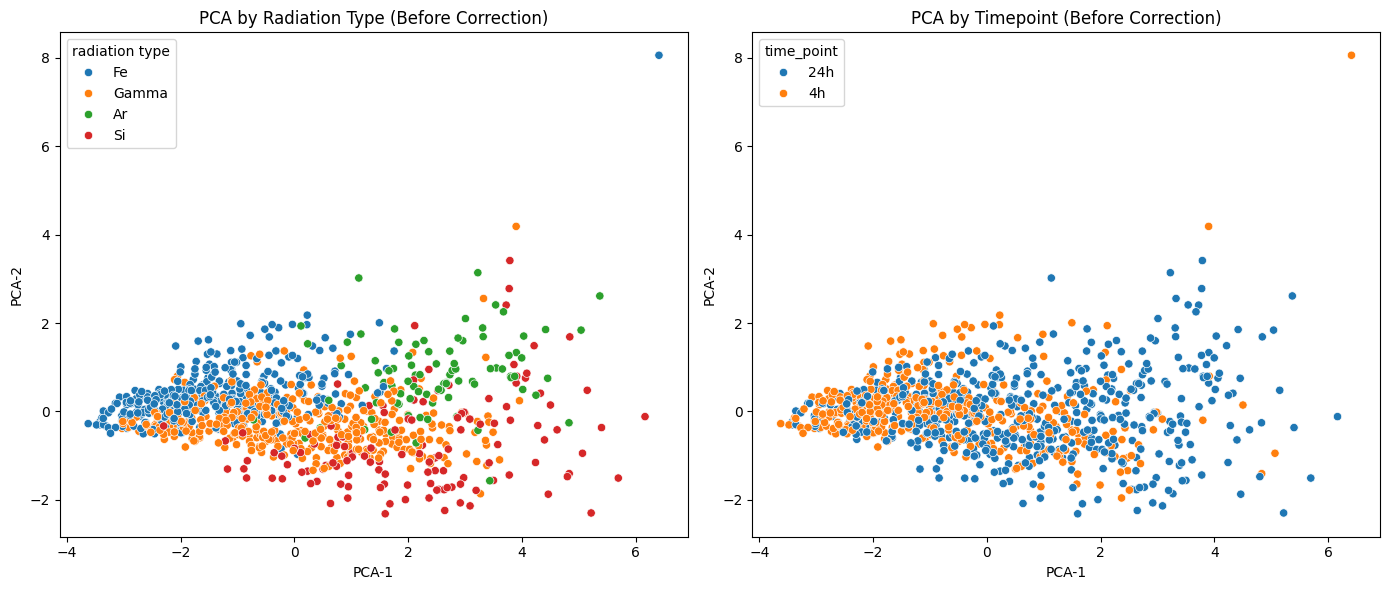

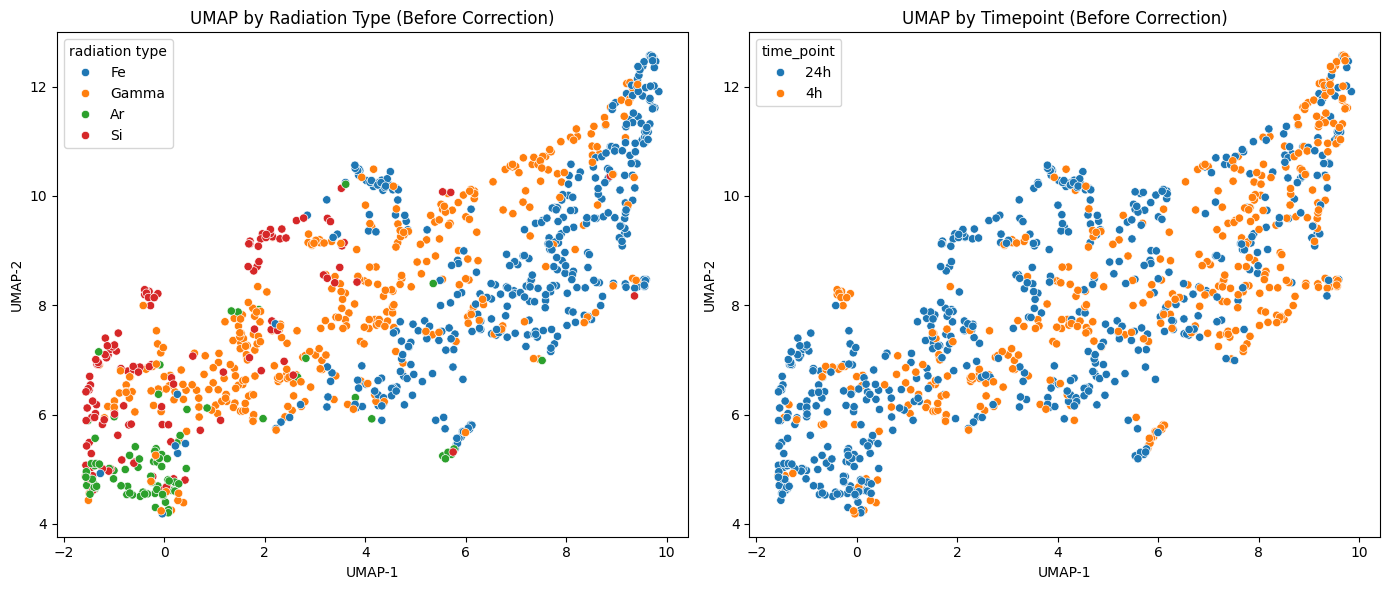

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


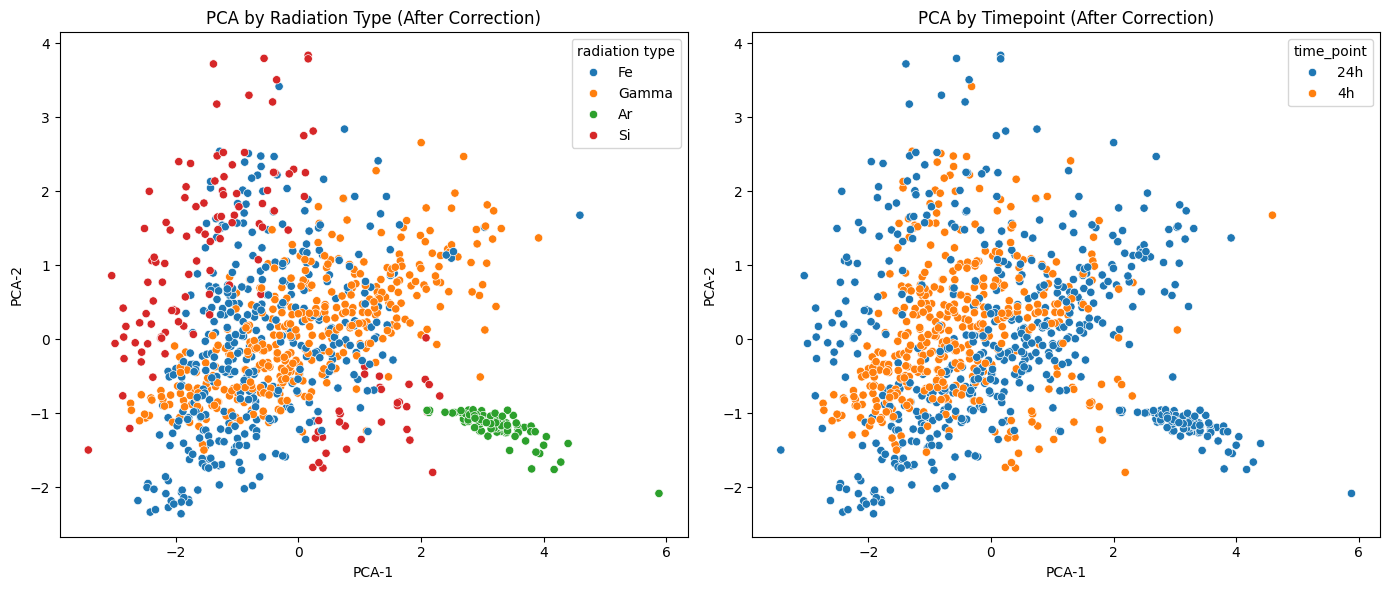

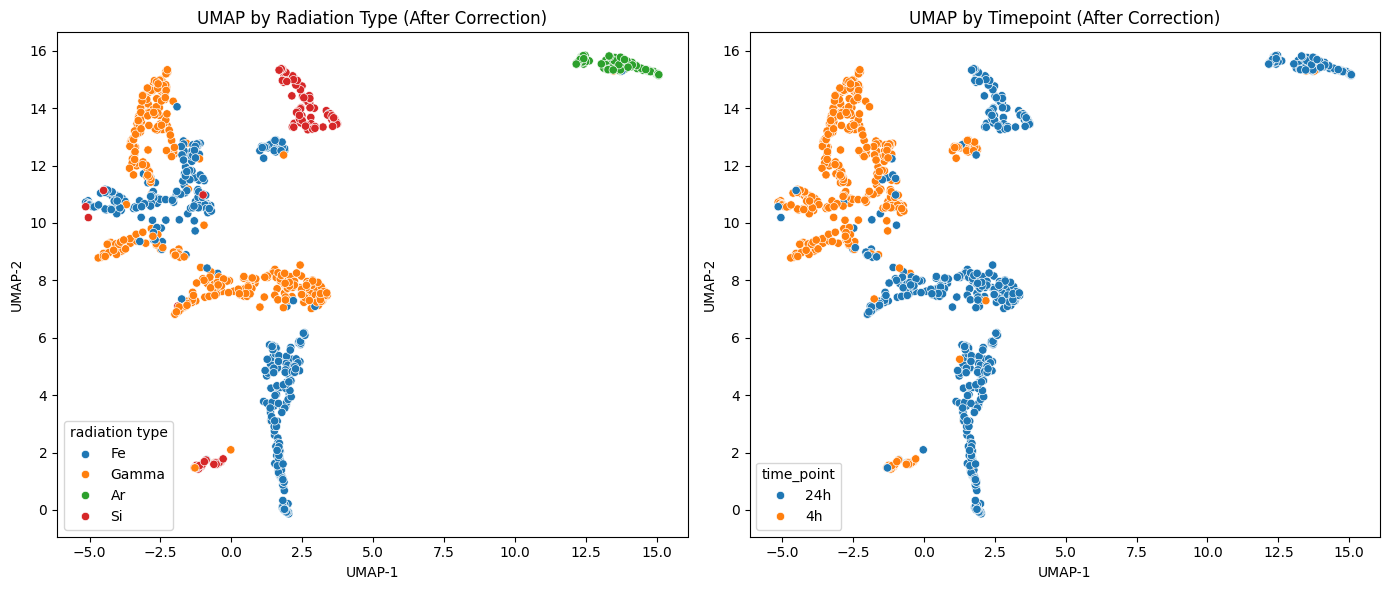

In [ ]:
"""
Batch Correction and Visualization Script for High-Throughput Radiation Response Data
--------------------------------------------------------------------------------------

VISUALLIZATION BASED MEAN_NFOCI AND MEAN_AF488, SO NO WORRIES ABOUT CELL TYPE

Purpose:
    Correct systematic differences between "All-old" (trusted baseline measurements)
    and "All-new" (repeat measurements) in high-throughput cellular imaging data,
    and visualize donor clustering before and after correction.

    This correction ensures harmonization across batches and extends to all
    new cell subtypes:
        ["CD 19", "CD 4", "Other_CD19_CD4", "CD 11b", "CD 8", "Other_CD11b_CD8"]

Method:
    • For each (radiation type, dose, time_point) group:
        - Fit a linear regression model: All-new → All-old for mean_nfoci and mean_AF488
        - Equation: corrected = a * original + b
    • Apply the learned (a, b) to All-new and its subtypes for the same condition

    • After correction:
        - Standardize features (z-score)
        - Reduce dimensionality using PCA and UMAP
        - Visualize donor-level embeddings, colored by radiation type and timepoint

Input:
    - CSV file: final_nfoci_AF488_size_with_demographics_and_old.csv

Output:
    - CSV file: corrected_nfoci_AF488_dataset.csv
      with corrected `mean_nfoci` and `mean_AF488` values for All-new and its subtypes

    - PCA and UMAP plots showing donor clustering:
        • Before correction
        • After correction

Note:
    All other metadata and measurements remain unchanged in the output.
    Visualizations support qualitative assessment of batch effects and biological consistency.
"""


import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# === LOAD DATA ===
df = pd.read_csv("/content/drive/MyDrive/final_nfoci_AF488_size_with_demographics_and_old_FFI_12.20_high.csv")
# Define features to correct
features = ["mean_nfoci", "mean_AF488"]
# Copy original data
corrected_df = df.copy()

# === BATCH CORRECTION ===
all_old = df[df["Cell Type"] == "All-old"]
all_new = df[df["Cell Type"] == "All-new"]
group_keys = ["radiation type", "dose", "time_point"]
correction_models = {}

for group_values, old_group in all_old.groupby(group_keys):
    if group_values not in all_new.groupby(group_keys).groups:
        continue

    new_group = all_new.groupby(group_keys).get_group(group_values)
    merged = pd.merge(
        old_group[["Patient ID"] + features],
        new_group[["Patient ID"] + features],
        on="Patient ID",
        suffixes=("_old", "_new")
    )

    if len(merged) < 3:
        continue

    correction_models[group_values] = {}
    for feature in features:
        x = merged[f"{feature}_new"].values.reshape(-1, 1)
        y = merged[f"{feature}_old"].values
        model = LinearRegression().fit(x, y)
        a, b = model.coef_[0], model.intercept_
        correction_models[group_values][feature] = (a, b)

# Apply correction to All-new and subtypes
subtype_labels = [
    "All-new", "CD 19", "CD 4", "Other_CD19_CD4",
    "CD 11b", "CD 8", "Other_CD11b_CD8"
]

for idx, row in corrected_df.iterrows():
    if row["Cell Type"] not in subtype_labels:
        continue

    key = (row["radiation type"], row["dose"], row["time_point"])
    if key not in correction_models:
        continue

    for feature in features:
        a, b = correction_models[key][feature]
        corrected_df.at[idx, feature] = a * row[feature] + b

# === SAVE CORRECTED FILE ===
corrected_df.to_csv("/content/drive/MyDrive/corrected_nfoci_AF488_dataset_12.20_high.csv", index=False)

# === VISUALIZATION: PCA & UMAP ===

def visualize_pca_umap_dose_response(df, title_suffix, cell_type="All-new"):
    """
    Visualize PCA and UMAP using 6-feature dose-response vectors:
    [nfoci_0Gy, nfoci_low, nfoci_high, AF488_0Gy, AF488_low, AF488_high]
    """

    # Define expected dose mapping
    dose_map = {
        "Gamma": [0.0, 0.1, 1.0],
        "Si": [0.0, 0.11, 0.3],
        "Ar": [0.0, 0.18, 0.5],
        "Fe": [0.0, 0.3, 0.82]
    }

    # Filter to relevant Cell Type
    subset = df[df["Cell Type"] == cell_type]

    # Assemble feature vectors
    records = []
    for (pid, rad_type, tp), group in subset.groupby(["Patient ID", "radiation type", "time_point"]):
        doses = dose_map.get(rad_type, [])
        if len(doses) != 3:
            continue

        row = {"Patient ID": pid, "radiation type": rad_type, "time_point": tp}
        for marker in ["mean_nfoci", "mean_AF488"]:
            for i, dose_label in enumerate(["0Gy", "low", "high"]):
                dose_val = doses[i]
                matched = group[np.isclose(group["dose"], dose_val)]
                val = matched[marker].mean() if not matched.empty else np.nan
                row[f"{marker}_{dose_label}"] = val
        records.append(row)

    matrix_df = pd.DataFrame(records).dropna()
    feature_cols = [col for col in matrix_df.columns if col.startswith("mean_")]
    X = StandardScaler().fit_transform(matrix_df[feature_cols])

    # PCA
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X)
    matrix_df["PCA-1"] = pca_coords[:, 0]
    matrix_df["PCA-2"] = pca_coords[:, 1]

    # UMAP
    reducer = umap.UMAP(random_state=42)
    umap_coords = reducer.fit_transform(X)
    matrix_df["UMAP-1"] = umap_coords[:, 0]
    matrix_df["UMAP-2"] = umap_coords[:, 1]

    # Plot PCA
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.scatterplot(data=matrix_df, x="PCA-1", y="PCA-2", hue="radiation type", ax=axs[0])
    axs[0].set_title(f"PCA by Radiation Type ({title_suffix})")

    sns.scatterplot(data=matrix_df, x="PCA-1", y="PCA-2", hue="time_point", ax=axs[1])
    axs[1].set_title(f"PCA by Timepoint ({title_suffix})")
    plt.tight_layout()
    plt.show()

    # Plot UMAP
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.scatterplot(data=matrix_df, x="UMAP-1", y="UMAP-2", hue="radiation type", ax=axs[0])
    axs[0].set_title(f"UMAP by Radiation Type ({title_suffix})")

    sns.scatterplot(data=matrix_df, x="UMAP-1", y="UMAP-2", hue="time_point", ax=axs[1])
    axs[1].set_title(f"UMAP by Timepoint ({title_suffix})")
    plt.tight_layout()
    plt.show()


# Visualize BEFORE correction
visualize_pca_umap_dose_response(df, "Before Correction", cell_type="All-new")

# Visualize AFTER correction
visualize_pca_umap_dose_response(corrected_df, "After Correction", cell_type="All-new")


In [ ]:
import pandas as pd
import numpy as np

# === Step 1: Load and initialize ===
df = pd.read_csv("/content/drive/MyDrive/corrected_nfoci_AF488_dataset_12.20_high.csv")
df_corrected = df.copy()

# === Step 2: Flag cell type category ===
def cell_category(cell_type):
    if cell_type == "All-new":
        return "allnew"
    elif cell_type.startswith("CD") or "Other_" in cell_type:
        return "subtype"
    else:
        return "ignore"

df_corrected["cell_category"] = df_corrected["Cell Type"].apply(cell_category)

# === Step 3: Build lookup tables ===
key_cols = ['Patient ID', 'radiation type', 'dose', 'time_point']

# Lookup All-new cell counts (na)
na_lookup = (
    df_corrected[df_corrected['cell_category'] == 'allnew']
    .set_index(key_cols)['n_cells']
    .to_dict()
)

# Lookup All-old cell counts (no)
no_lookup = (
    df_corrected[df_corrected['Cell Type'] == 'All-old']
    .set_index(key_cols)['n_cells']
    .to_dict()
)

# === Step 4: Add na, no, nac, proportion, and nac_subtype ===
df_corrected['na'] = df_corrected.apply(
    lambda row: na_lookup.get((row['Patient ID'], row['radiation type'], row['dose'], row['time_point'])), axis=1
)
df_corrected['no'] = df_corrected.apply(
    lambda row: no_lookup.get((row['Patient ID'], row['radiation type'], row['dose'], row['time_point'])), axis=1
)
df_corrected['nac'] = df_corrected.apply(
    lambda row: (row['na'] + row['no']) / 2 if pd.notnull(row['na']) and pd.notnull(row['no']) else None, axis=1
)

# === Step 5: Scale subtype counts and complete the table ===
def compute_proportion(row):
    if row['Cell Type'] == 'All-new' and pd.notnull(row['na']):
        return 100.0
    elif row['cell_category'] == 'subtype' and pd.notnull(row['na']):
        return (row['n_cells'] / row['na']) * 100
    else:
        return None

def compute_nac_subtype(row):
    if row['Cell Type'] == 'All-new' and pd.notnull(row['nac']):
        return row['nac']
    elif row['cell_category'] == 'subtype' and pd.notnull(row['na']) and pd.notnull(row['nac']):
        return (row['n_cells'] * row['nac'] / row['na'])
    else:
        return None

df_corrected['proportion_of_allnew'] = df_corrected.apply(compute_proportion, axis=1)
df_corrected['nac_subtype'] = df_corrected.apply(compute_nac_subtype, axis=1)

# === Step 6: Clean up and save ===
df_corrected.drop(columns='cell_category', inplace=True)
df_corrected.to_csv('/content/drive/MyDrive/immune_cells_corrected_output_12.20_high_wp2a.csv', index=False)

print("✅ Updated dataset saved with corrected naming (na, no, nac, proportions).")


✅ Updated dataset saved with corrected naming (na, no, nac, proportions).
